In [56]:
#mnist decision tree 

import os
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from IPython.display import display
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score

In [57]:
#getting MNIST Data
from keras.datasets import mnist

# load dataset
(x_train, y_train),(x_test, y_test) = mnist.load_data()

# image dimensions (assumed square)
image_size = x_train.shape[1]
input_size = image_size * image_size
input_size

# resize and normalize
x_train = np.reshape(x_train, [-1, input_size])
x_train = x_train.astype('float32') / 255
x_test = np.reshape(x_test, [-1, input_size])
x_test = x_test.astype('float32') / 255

In [58]:
#Getting dense layer outputs

def layer_outputs(data,layer):
    
    selected_layers = [layer]


    test_input = data
    num_inp = len(test_input)

    model = keras.models.load_model(r"C:\Users\benic\Desktop\MNISTModel.h5")

    layer_outputs = [model.layers[layer].output for layer in selected_layers]
    activation_model = keras.models.Model(inputs=model.input, outputs=layer_outputs)
    activations = activation_model.predict(test_input)


    acts_combined = []
    if type(activations) is list:
        activations = [x.reshape(num_inp, -1) for x in activations]
        activations = np.hstack(activations)
    else:
        activations = activations.reshape(num_inp, -1)

    acts_combined.append(activations)
    return acts_combined


In [59]:
#Changing dense layer output values into activation values (on/off)

def transform_to_activation_values(array_count, data, layer):

    acts_combined = layer_outputs(data, 1)

    newarr = np.array_split(acts_combined[0], len(acts_combined[0]))
    #print(newarr)


    arr_count = -1
    finished = False
    act_array = []

    while finished == False:
        arr_count = arr_count + 1
        intermit_arr = newarr[arr_count][0]
        count = 0
        for i in newarr[arr_count][0]:
            if i > 0:
                intermit_arr[count] = 1
                count = count + 1
            else:
                intermit_arr[count] = 0
                count = count + 1
        act_array.append(intermit_arr)
        if arr_count == array_count:
            finished = True

    #print(act_array)
    #print(len(act_array))
    return act_array

In [60]:
#checking if the data points were correctly classified or not

def is_data_correctly_classified(data, label_data):
    correctly_classified = []

    batch_size = 128

    # Loop through data points in batches
    for index in range(0, len(data), batch_size):
        batch_data = data[index:index + batch_size]
        batch_labels = label_data[index:index + batch_size]
        
        # Predict the labels using the trained model
        batch_predictions = np.argmax(model.predict(batch_data), axis=1)
        
        # Check if the batch data points were correctly classified
        batch_correct = (batch_predictions == batch_labels).astype(int)
        correctly_classified.extend(batch_correct)

    # Convert the list to a NumPy array
    correctly_classified = np.array(correctly_classified)

    # Print the accuracy
    accuracy = np.mean(correctly_classified)
    #print("Accuracy:", accuracy)

    #print(correctly_classified)
    return correctly_classified



In [ ]:
#Building the decision tree
act_array = transform_to_activation_values(59999, x_train, 1)
correctly_classified = is_data_correctly_classified(x_train, y_train)
d = {'suffix': act_array, 'class': correctly_classified}
df = pd.DataFrame(data=d)
display(df.head())
df_train = df.sample(frac=1, random_state=0)
print(df_train.shape)
df_valid = df.drop(df_train.index)
train_suffixes = pd.DataFrame(df_train['suffix'].to_list(), index=df_train.index)
train_outputs = df_train['class']

valid_suffixes = pd.DataFrame(df_valid['suffix'].to_list(), index=df_valid.index)
valid_outputs = df_valid['class']

#print(train_suffixes.shape)
#print(act_array.shape)


basic_estimator = tree.DecisionTreeClassifier(criterion="gini") #create decision tree classifier object

basic_estimator.fit(train_suffixes, train_outputs) #train decision tree classifier

basic_estimator.get_n_leaves()

basic_estimator.get_depth()

print(basic_estimator.n_features_in_) #should print number of neurons/features

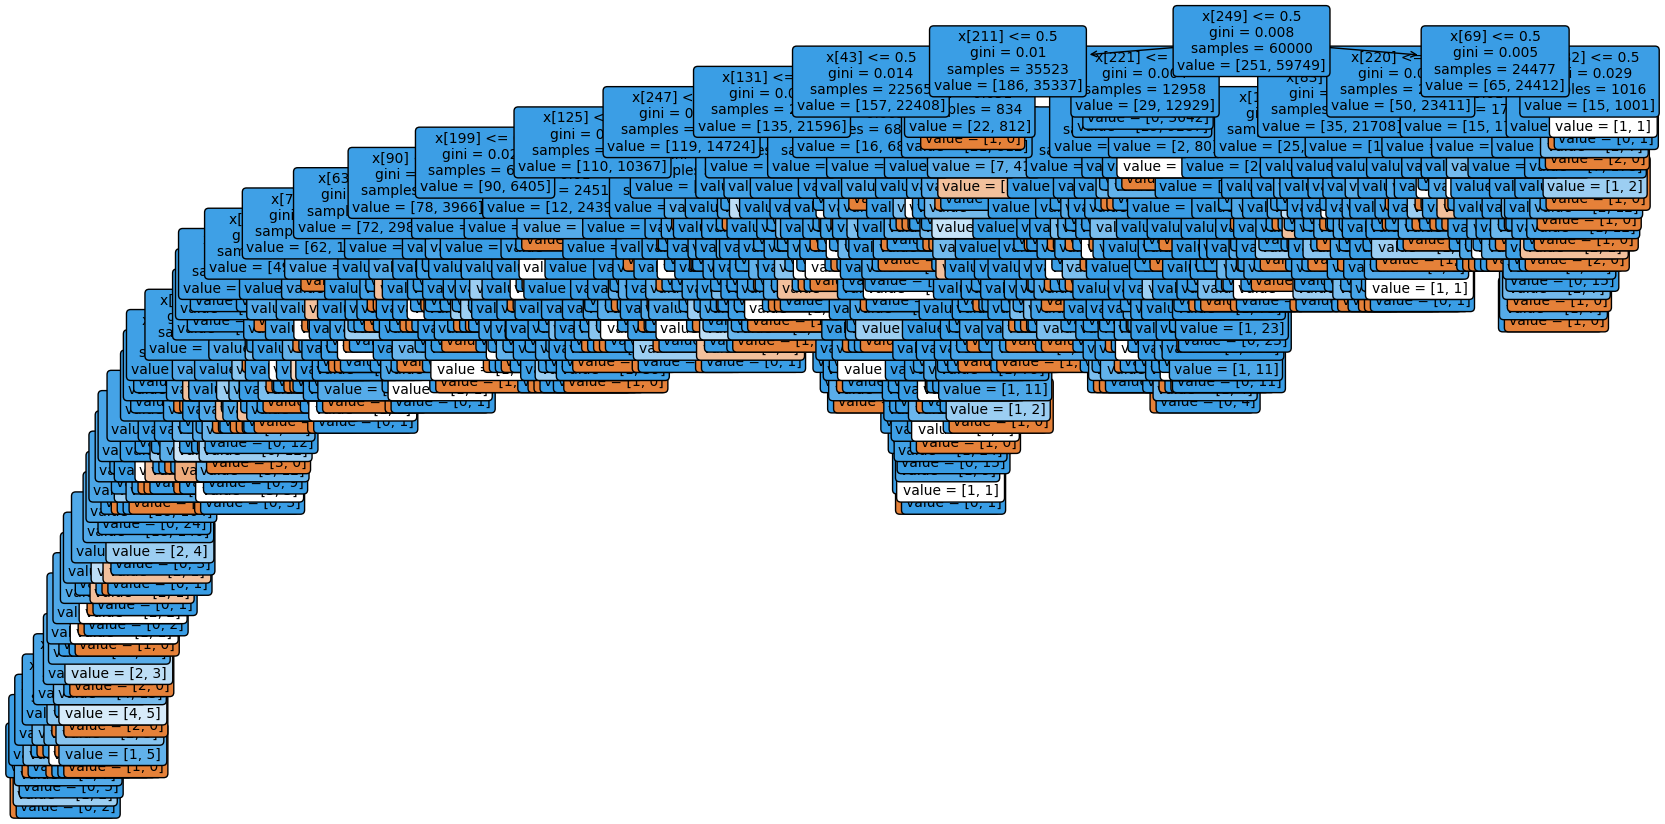

In [62]:
#Visualizing the decision tree

def plot_decision_tree(decision_tree, feature_names=None):
    """Plots the decision tree."""
    plt.figure(figsize=(20, 10))
    plot_tree(decision_tree, feature_names=feature_names, filled=True, rounded=True, fontsize=10)
    plt.show() 

plot_decision_tree(basic_estimator)

In [ ]:
#accuracy of the decision tree


# Preprocess the MNIST test data to obtain neuron activation patterns

acts_combined = layer_outputs(x_test, 1)

neuron_activation_patterns = transform_to_activation_values(9999, x_test, 1)

correctly_classified = is_data_correctly_classified(x_test, y_test)




# Predict using the loaded decision tree
predicted_labels = basic_estimator.predict(neuron_activation_patterns)


# Calculate accuracy
accuracy = accuracy_score(predicted_labels, correctly_classified)

print(f"Decision Tree Accuracy on MNIST Test Data: {accuracy:.4f}")

In [ ]:
# Extract feature names (if available)
feature_names = train_suffixes.columns

# Get the tree structure
tree_structure = basic_estimator.tree_

# Initialize a counter for all extracted patterns
all_pattern_count = 0

def extract_paths(tree, node=0, path=[]):
    global all_pattern_count  # Declare the global counter variable

    if tree.feature[node] != -2:  # Check for non-leaf node
        feature_name = feature_names[tree.feature[node]]
        threshold = tree.threshold[node]
        path.append((feature_name, threshold, 'left'))
        extract_paths(tree, tree.children_left[node], path)
        path.pop()
        
        path.append((feature_name, threshold, 'right'))
        extract_paths(tree, tree.children_right[node], path)
        path.pop()
    else:
        all_pattern_count += 1  # Increment the counter for all patterns
        path_str = ', '.join(f"{feature} <= {threshold}" if direction == 'left' else f"{feature} > {threshold}" for feature, threshold, direction in path)
        print(f"Path: {path_str}")

# Start extracting paths from the root
extract_paths(tree_structure)

# Print the total number of extracted patterns
print(f"Total All Patterns: {all_pattern_count}")


In [65]:
# Extract feature names (if available)
feature_names = train_suffixes.columns

# Get the tree structure
tree_structure = basic_estimator.tree_

# Initialize a counter for the extracted incorrect patterns
incorrect_pattern_count = 0

def extract_paths(tree, node=0, path=[]):
    global incorrect_pattern_count  # Declare the global counter variable

    if tree.feature[node] != -2:  # Check for non-leaf node
        feature_name = feature_names[tree.feature[node]]
        threshold = tree.threshold[node]
        path.append((feature_name, threshold, 'left'))
        extract_paths(tree, tree.children_left[node], path)
        path.pop()
        
        path.append((feature_name, threshold, 'right'))
        extract_paths(tree, tree.children_right[node], path)
        path.pop()
    else:
        path_str = ', '.join(f"{feature} <= {threshold}" if direction == 'left' else f"{feature} > {threshold}" for feature, threshold, direction in path)
        class_label = "Correct" if tree.value[node][0][1] >= tree.value[node][0][0] else "Incorrect"
        if class_label == "Incorrect":
            incorrect_pattern_count += 1  # Increment the counter
            print(f"Path: {path_str} => Class: {class_label}")

# Start extracting paths from the root
extract_paths(tree_structure)

# Print the total number of extracted incorrect patterns
print(f"Total Incorrect Patterns: {incorrect_pattern_count}")

Path: 249 <= 0.5, 211 <= 0.5, 43 <= 0.5, 131 <= 0.5, 247 <= 0.5, 125 <= 0.5, 199 <= 0.5, 90 <= 0.5, 63 <= 0.5, 7 <= 0.5, 16 <= 0.5, 28 <= 0.5, 35 <= 0.5, 220 <= 0.5, 103 <= 0.5, 112 <= 0.5, 55 <= 0.5, 180 <= 0.5, 189 <= 0.5, 200 <= 0.5, 89 <= 0.5, 114 <= 0.5, 230 <= 0.5, 78 <= 0.5, 37 <= 0.5, 186 <= 0.5, 164 <= 0.5, 118 <= 0.5, 136 <= 0.5, 115 <= 0.5, 183 <= 0.5, 137 <= 0.5, 172 <= 0.5, 140 <= 0.5, 240 > 0.5, 255 <= 0.5, 49 <= 0.5 => Class: Incorrect
Path: 249 <= 0.5, 211 <= 0.5, 43 <= 0.5, 131 <= 0.5, 247 <= 0.5, 125 <= 0.5, 199 <= 0.5, 90 <= 0.5, 63 <= 0.5, 7 <= 0.5, 16 <= 0.5, 28 <= 0.5, 35 <= 0.5, 220 <= 0.5, 103 <= 0.5, 112 <= 0.5, 55 <= 0.5, 180 <= 0.5, 189 <= 0.5, 200 <= 0.5, 89 <= 0.5, 114 <= 0.5, 230 <= 0.5, 78 <= 0.5, 37 <= 0.5, 186 <= 0.5, 164 <= 0.5, 118 <= 0.5, 136 <= 0.5, 115 <= 0.5, 183 <= 0.5, 137 <= 0.5, 172 <= 0.5, 140 > 0.5, 188 <= 0.5 => Class: Incorrect
Path: 249 <= 0.5, 211 <= 0.5, 43 <= 0.5, 131 <= 0.5, 247 <= 0.5, 125 <= 0.5, 199 <= 0.5, 90 <= 0.5, 63 <= 0.5, 7 